In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import linalg
from cmath import *
from math import *
import numpy as np


In [4]:
"""
Returns the angular frequency w('omega') given the linear frequency f('freq')
"""
def omega(freq):
    return 2*pi*freq

"""
Returns the phasorial representation of a resistor given it's resistance ('R')
"""
def Z_R(R):
    return R

"""
Returns the phasorial representation of a capacitor given it's capacitance (in F) and the system frequency (both in rad/s or in Hz)
"""
def Z_C(w, C, f_in_Hz=False):
    if f_in_Hz:
        w = omega(w)
    return 1/(1j*w*C)

"""
Returns the phasorial representation of a inductor given it's inductance (in H) and the system frequency (in both rad/s or in Hz)
"""
def Z_L(w, L, f_in_Hz=False):
    if f_in_Hz:
        w = omega(w)
    return 1j*w*L
"""
Returns the polar representation of a phasor given it's cartesian (rectangular) representation
"""
def Z_rect_to_pol(Z):
    return abs(Z), degrees(phase(Z))

"""
Shows a phasorial representation (in both polar and rectangular representations)
"""
def Z_show(Z, polar=True, before_text="", after_text=" "):
    if polar:
        mod, ang = Z_rect_to_pol(Z)
        print(before_text+"{} < {}º".format(mod, ang) + after_text)
    else:
        print(Z)
    
"""
Returns the equivalent reactance given two reactances connected in parallel
"""
def in_parallel(Za, Zb):
    return (Za * Zb) / (Za + Zb)

"""
Returns the equivalent reactance given two reactances connected in series
"""    
def in_series(Za, Zb):
    return Za + Zb

"""L
Returns the current on a specific component given the Ohm's law (I = U / R)
"""
def current(Vt, Zx):
    return Vt / Zx

"""
Returns the voltage on a specific component given the Ohm's law (U = R * I)
"""
def voltage(It, Zx):
    return It*Zx

"""
Returns the currents on a tranformer component given the equivalent impedance of each side of the circuit(Z1, Z2)
"""
def transformer(v1, w, m, z1, z2):
    xm = 1j*w*m
    Z = np.array( [[z1, -xm], [-xm, z2]] )
    V = np.array( [v1, 0] )
    I = np.dot(linalg.inv(Z), V)
    return I[0], I[1]

"""
Returns the 
"""
def power(Vp, I):
    Vef = Vp/sqrt(2)
    Ief = I/sqrt(2)
    S = Vef*Ief.conjugate()
    return S

![Circuit Model](modelo_v1.png "WPT Circuit Model")

In [11]:
# Natural ressonance frequency:


n = 200
# 
lista_k = np.linspace(0, 1, n)
lista_w = np.linspace(1, 5000, n)

lista_v2 = []
lista_i1 = []
lista_i2 = []
lista_P1 = []
lista_P2 = []
lista_Ef = []

# r1=0.5
# r2=0.5
# l1=300e-3
# l2=300e-3
# f=60
k=0.5

#for k in lista_k:

for w in lista_w:
    # 
    V = 1e3 # V
    # 
    L = 300e-3
    C = 1e-6
    R = 0.5
    # Phasorial Representation of all components:
    XR1 = Z_R(R)     # Ohm
    XR2 = Z_R(R)     # Ohm
    XL1 = Z_L(w, L)  # Ohm
    XL2 = Z_L(w, L)  # Ohm
    XC1 = Z_C(w, C)  # Ohm
    XC2 = Z_C(w, C)  # Ohm
    XRC = Z_R(100)   # Ohm

    # Association between components (Transformer):
    Zp1 = in_series(XC1, XR1)
    Z1 = in_series(XL1, Zp1)

    Zp2 = in_parallel(XC2, XRC)
    Zp3 = in_series(XR2, XL2)
    Z2 = in_series(Zp2, Zp3)


    m = k*sqrt(L*L)
    I1, I2 = transformer(V, w, m, Z1, Z2)
    lista_i1.append(abs(I1))
    lista_i2.append(abs(I2))

    Irc = I2*Z2/XRC

    Pf = abs(power(V, I1))
    Prc = abs(power(XRC*Irc, Irc))
    lista_P1.append( Pf )
    lista_P2.append( Prc )

    lista_Ef.append(Prc/Pf)
    

# Ressonance frequency:
w = 1/sqrt(L*C)

plt.plot(lista_w, lista_i1, label="I1")
plt.plot(lista_w, lista_i2, label="I2")
plt.axvline(w, color='r', linestyle='-', label='Fres')
plt.legend()
plt.show()

plt.plot(lista_w, lista_P1, label="P1")
plt.plot(lista_w, lista_P2, label="P2")
plt.legend()
plt.show()

plt.plot(lista_w, lista_Ef, label="Pef")
plt.legend()
plt.show()



In [12]:
def wireless_power_plant(k, w):
    #
    V = 110 # V
    # 
    L = 300e-3
    C = 1e-6
    R = 0.5
    # Phasorial Representation of all components:
    XR1 = Z_R(R)     # Ohm
    XR2 = Z_R(R)     # Ohm
    XL1 = Z_L(w, L)  # Ohm
    XL2 = Z_L(w, L)  # Ohm
    XC1 = Z_C(w, C)  # Ohm
    XC2 = Z_C(w, C)  # Ohm
    XRC = Z_R(100)   # Ohm
    # Association between components (Transformer's left side):
    Zp1 = in_series(XC1, XR1)
    Z1 = in_series(XL1, Zp1)
    # Association between components (Transformer's right side):
    Zp2 = in_parallel(XC2, XRC)
    Zp3 = in_series(XR2, XL2)
    Z2 = in_series(Zp2, Zp3)

    # Mutual 
    m = k*sqrt(L*L)
    I1, I2 = transformer(V, w, m, Z1, Z2)

    Irc = I2*Z2/XRC

    Pf = abs(power(V, I1))
    Prc = abs(power(XRC*Irc, Irc))

    G = Prc/Pf
    return G



n = 200
# 
lista_k = np.linspace(0.1, 1, n)
lista_w = np.linspace(1, 5000, n)
G = np.zeros(n, n)

for k in lista_k:

    for w in lista_w:

k, w = np.meshgrid(lista_k, lista_w)
G = wireless_power_plant(k, w)

# Ressonance frequency:
w = 1/sqrt(L*C)

# 
fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
surf = ax.plot_surface(k, w, G, cmap=cm.plasma, linewidth=0, antialiased=False)



(1.8381902616911876, -12.797263688715953)

In [42]:
Vef = Vp/sqrt(2)
Ief = I/sqrt(2)
S = ( Vef )*Ief.conjugate()
#Z_rect_to_pol(S)
S

(17.925294939525358+4.071626843002462j)

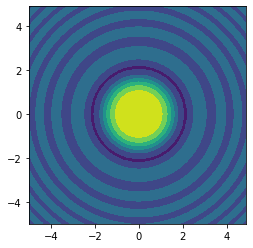

In [36]:
x = np.arange(-5, 5, 0.1)

y = np.arange(-5, 5, 0.1)

xx, yy = np.meshgrid(x, y, sparse=True)

z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)

h = plt.contourf(x, y, z)

plt.axis('scaled')

plt.show()

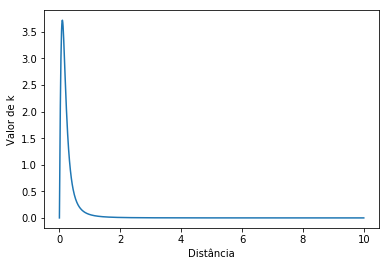

In [16]:
def self_inductance(N, R, mi0):
    # flux = i*pi*e**(-pi) * (4*e**pi + (2**(3/2) - 1)*e**(2**(3/2)) + 1 )*N*R*mi0
    # return flux/i
    return (pi*e**(-pi) * (4*e**pi + (2**(3/2) - 1)*e**(2**(3/2)) + 1 )*N*R*mi0)/(2**(13/2))

def indutanciaMutua(N,R,mi0,d):
    # flux=(i1*pi*N*R**2*d*(sqrt(d**2+R**2)-d)*mi0)/((d**2+R**2)**(3/2))
    # return flux/i1
    return (pi*N*R**2*d*(sqrt(d**2+R**2)-d)*mi0)/((d**2+R**2)**(3/2))

def calcula_k(M,L1,L2):
    return M/sqrt(L1*L2)


lista_d=np.linspace(0,10,1000)
N=200
R=0.2
mi0=4*pi*10e-7

lista_k=[]
for d in lista_d:
    m=indutanciaMutua(N,R,mi0,d)
    L1=self_inductance(N,R,mi0)
    L2=self_inductance(N,R,mi0)
    k=calcula_k(m,L1,L2)
    lista_k.append(k)

plt.plot(lista_d,lista_k)
plt.xlabel("Distância")
plt.ylabel("Valor de k")
plt.show()


C:\Users\thpro\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


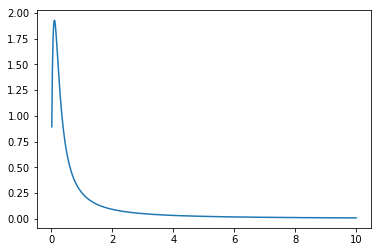

In [14]:
def teste_arthur(N,R,d,mi0):
    flux=(pi*N*R**2*d*(sqrt(d**2+R**2)-d)*mi0)/((d**2+R**2)**(3/2))
    flux2 = (pi*e**(-pi) * (4*e**pi + (2**(3/2) - 1)*e**(2**(3/2)) + 1 )*N*R*mi0)/(2**(13/2))
    return flux/(sqrt(flux2)*sqrt(flux))

lista_d=np.linspace(0,10,1000)
N=200
R=0.2
mi0=4*pi*10e-7

lista_k=[]
for d in lista_d:
    k=teste_arthur(N,R,d,mi0)
    lista_k.append(k)

plt.plot(lista_d,lista_k)
plt.show()


In [ ]:
def transformer(v1, w, m, z1, z2):
    xm = 1j*w*m
    Z = np.array( [[z1, -xm], [-xm, z2]] )
    V = np.array( [v1, 0] )
    I = np.dot(linalg.inv(Z), V)
    return I[0], I[1]

N=200
R=0.2
resistividade=0.025
lista_r2=[1,5,10,50,100,500,1000]
v1=15/2
XR1 = Z_R(R)     # Ohm
XR2 = Z_R(R)     # Ohm
XL1 = Z_L(w, L)  # Ohm
XL2 = Z_L(w, L)  # Ohm
XC1 = Z_C(w, C)  # Ohm
XC2 = Z_C(w, C)  # Ohm
XRC = Z_R(100)   # Ohm
    # Association between components (Transformer's left side):
Zp1 = in_series(XC1, XR1)
Z1 = in_series(XL1, Zp1)
    # Association between components (Transformer's right side):
Zp2 = in_parallel(XC2, XRC)
Zp3 = in_series(XR2, XL2)
Z2 = in_series(Zp2, Zp3)

for d in lista_d:
    